In [1]:
# Install cell, Install if needed

#pip install sklearn
#pip install Keras-Preprocessing

# Resources


ResNet Resource: https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

Knowledge Distillation: https://medium.com/analytics-vidhya/knowledge-distillation-in-a-deep-neural-network-c9dd59aff89b

Knowledge Distiller Code: https://keras.io/examples/vision/knowledge_distillation/

F1 Score and AUC Score average selection: https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
                                          Since the dataset is binary, the average can be binary in this project

Resnet Model:https://www.kaggle.com/code/iabhishekmaurya/transfer-learning-resnet50v2

Mobile Model: https://www.kaggle.com/code/xhlulu/training-mobilenet-v2-in-4-min/script


In [2]:
import tensorflow as tf
tf.test.is_built_with_cuda()

True

In [3]:
#import block

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt
from keras_flops import get_flops
import pandas as pd

import tensorflow.keras as K

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image
from skimage import io

from keras.models import Model
import keras
tf.enable_v2_behavior()

In [4]:
#Variable block
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 25
LEARNING_RATE_TEACHER = 0.0001
LEARNING_RATE_STUDENT_KD = 0.001
LEARNING_RATE_STUDENT_SC = 0.001

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
#GPU Memory Reset
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [25]:
#run when job fail happens
reset_keras()

17109


# Load Data

In [8]:
#load data use panda

#read annotation file
annotations = pd.read_csv("./annotations.csv", skiprows = 1,
                         names = ["Image Name","Majority Vote Label","Number of Annotations who Selected SSA(Out of 7)","Partition"])
annotations.head()

#Create dataframe
df = pd.DataFrame(annotations,
                 columns = ["Image Name","Majority Vote Label","Number of Annotations who Selected SSA(Out of 7)", "Partition"])
df.set_index("Image Name",inplace = True)

df.head()

,Majority Vote Label,Number of Annotations who Selected SSA(Out of 7),Partition
Image Name,,,
MHIST_aaa.png,SSA,6,train
MHIST_aab.png,HP,0,train
MHIST_aac.png,SSA,5,train
MHIST_aae.png,HP,1,train
MHIST_aaf.png,SSA,5,train


# Data Augmentation

In [9]:
#resource: https://www.youtube.com/watch?v=ccdssX4rIh8
SIZE = 224
image_directory = "images/"

datagen = ImageDataGenerator(
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.5,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

all_images = os.listdir(image_directory)

#read test images and process them
test_images = []
test_labels = []
for i, image_name in enumerate(all_images):
    if df.loc[image_name][2] == 'test':
        #load test image and label
        image = io.imread(image_directory+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        image_array = np.array(image)
        test_images.append(image_array)
        test_labels.append(df.loc[image_name][0])
            
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print("Test Image Shape: {}".format(test_images.shape))
print("Test Image label: {}".format(test_labels.shape))

#read train images and process them
train_images = []
train_labels = []
for i, image_name in enumerate(all_images):
    if df.loc[image_name][2] == 'train':
        image = io.imread(image_directory+image_name)
        image = Image.fromarray(image,'RGB')
        image = image.resize((SIZE,SIZE))
        image_array = np.array(image)
        train_images.append(image_array)
        train_labels.append(df.loc[image_name][0])
        image_array = image_array.reshape((1,)+image_array.shape)
        iterator = datagen.flow(image_array,batch_size = 1)
        for i in range(1,3):
            batch = iterator.next()
            image = batch[0].astype('uint8')
            train_images.append(image)
            train_labels.append(df.loc[image_name][0])
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print("Train Image Shape: {}".format(train_images.shape))
print("Train Label Shape: {}".format(train_labels.shape))

Test Image Shape: (977, 224, 224, 3)
Test Image label: (977,)
Train Image Shape: (6525, 224, 224, 3)
Train Label Shape: (6525,)


In [10]:
#normalize the test images and train images
train_images_normalized = train_images.astype('float32')/255.0
test_images_normalized = test_images.astype('float32')/255.0

#encode the labels
encoder = LabelEncoder()
encoder.fit(train_labels)
train_labels_encoded = encoder.transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

In [11]:
print("Unique Value in train labels: {}".format(np.unique(train_labels_encoded)))
print("Unique Value in test labels: {}".format(np.unique(test_labels_encoded)))

print("The number of 1 in train dataset: {}".format(train_labels_encoded.sum()))
print("The number of 0 in train dataset: {}".format(6525-train_labels_encoded.sum()))

print("The number of 1 in test dataset: {}".format(test_labels_encoded.sum()))
print("The number of 0 in test dataset: {}".format(977-test_labels_encoded.sum()))

Unique Value in train labels: [0 1]
Unique Value in test labels: [0 1]
The number of 1 in train dataset: 1890
The number of 0 in train dataset: 4635
The number of 1 in test dataset: 360
The number of 0 in test dataset: 617


# Create Model

In [12]:
#teacher model

def teacher_model():
    res_model = K.applications.resnet_v2.ResNet50V2(include_top = False, weights="imagenet",input_shape=(224,224,3))
    for layer in res_model.layers:
        layer.trainable = False
    x = K.layers.MaxPooling2D(pool_size = (2,2))(res_model.output)
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(128,activation = "relu")(x)
    outputs = K.layers.Dense(2,activation="softmax")(x) 
    teacher = Model(inputs = res_model.input, outputs = outputs)
    return teacher

#student model
def student_model():
    mob_model = K.applications.mobilenet_v2.MobileNetV2(include_top = False, weights="imagenet", input_shape=(224,224,3))
    for layer in mob_model.layers:
        layer.trainable = False
    x = K.layers.GlobalMaxPooling2D()(mob_model.output)
    outputs = K.layers.Dense(2, activation = "softmax")(x)
    student = Model(inputs = mob_model.input, outputs = outputs)
    return student

In [13]:
class Distiller(Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=4,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        # return results
        return y_prediction

# Model Train

## Fine Tuning

In [14]:
#Reset GPU Memory
reset_keras()
#Train teacher
teacher = teacher_model()

teacher.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_TEACHER),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
teacher.fit(train_images_normalized, train_labels_encoded, epochs = FINE_TUNE_EPOCHS)

110
Epoch 1/25
204/204 [==============================] - 17s 58ms/step - loss: 0.6000 - sparse_categorical_accuracy: 0.7439
Epoch 2/25
204/204 [==============================] - 11s 56ms/step - loss: 0.2983 - sparse_categorical_accuracy: 0.8733
Epoch 3/25
204/204 [==============================] - 11s 56ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.9408
Epoch 4/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0738 - sparse_categorical_accuracy: 0.9847
Epoch 5/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0301 - sparse_categorical_accuracy: 0.9985
Epoch 6/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0136 - sparse_categorical_accuracy: 1.0000
Epoch 7/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0077 - sparse_categorical_accuracy: 1.0000
Epoch 8/25
204/204 [==============================] - 11s 56ms/step - loss: 0.0051 - sparse_categorical_accuracy: 1.0000
Epoch 9/25
204/204 [========

In [15]:
reset_keras()
y_pred = teacher.predict(test_images_normalized)
y_pred = np.rint(y_pred)
result = np.argmax(y_pred,axis = 1)
f1_score_result = metrics.f1_score(test_labels_encoded,result)
print("Teacher Model Fine Tune f1 score: {}".format(f1_score_result))

1153
31/31 [==============================] - 3s 70ms/step
Teacher Model Fine Tune f1 score: 0.7272727272727273


In [16]:
#First Tune T
reset_keras()
Ts = [1,2,4,16,32,64]
student_models = []
for T in Ts:
    print("T = {}".format(T))
    student = student_model()
    student_models.append(student)
    distiller = Distiller(student = student,teacher = teacher)
    distiller.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_KD),
        metrics = [keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn = keras.losses.SparseCategoricalCrossentropy(),
        distillation_loss_fn = keras.losses.KLDivergence(),
        alpha = 0.5,
        temperature = T
    )
    distiller.fit(train_images_normalized,train_labels_encoded,epochs = FINE_TUNE_EPOCHS)
    reset_keras()

756
T = 1
Epoch 1/25
204/204 [==============================] - 20s 81ms/step - sparse_categorical_accuracy: 0.7111 - student_loss: 0.8662 - distillation_loss: 0.1022
Epoch 2/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.7608 - student_loss: 0.6425 - distillation_loss: 0.0821
Epoch 3/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.7841 - student_loss: 0.5648 - distillation_loss: 0.0741
Epoch 4/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.7905 - student_loss: 0.5279 - distillation_loss: 0.0709
Epoch 5/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.7983 - student_loss: 0.5079 - distillation_loss: 0.0684
Epoch 6/25
204/204 [==============================] - 16s 79ms/step - sparse_categorical_accuracy: 0.8077 - student_loss: 0.4808 - distillation_loss: 0.0642
Epoch 7/25
204/204 [============================

In [17]:
reset_keras()
student_f1_results = []
for model in student_models:
    y_pred = model.predict(test_images_normalized)
    y_pred = np.rint(y_pred)
    result = np.argmax(y_pred, axis=1)
    f1_score_result = metrics.f1_score(test_labels_encoded,result)
    student_f1_results.append(f1_score_result)
    reset_keras()

110
31/31 [==============================] - 1s 30ms/step
756
31/31 [==============================] - 1s 21ms/step
756
31/31 [==============================] - 1s 21ms/step
756
31/31 [==============================] - 1s 21ms/step
756
31/31 [==============================] - 1s 21ms/step
756
31/31 [==============================] - 1s 21ms/step
756


In [18]:
print(student_f1_results)

[0.6577777777777778, 0.6962025316455697, 0.6417445482866044, 0.6766541822721598, 0.6796116504854369, 0.649859943977591]


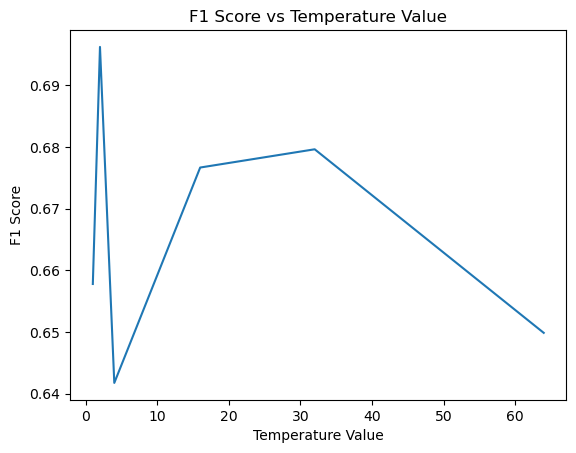

In [19]:
#plot the result vs Temperature
plt.plot(Ts,student_f1_results,label = "F1 Scores")
plt.xlabel("Temperature Value")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Temperature Value")
plt.show()

In [20]:
max_index = student_f1_results.index(max(student_f1_results))
T_max = Ts[max_index]
print("T value with maximum F1 Score is: {}".format(T_max))

T value with maximum F1 Score is: 2


Based on the graph and data, the F1 score reaches maximum when T = 2.

In [23]:
#Tune Alpha
#Based on the previous result, when T=4, the F1 Score and AUC score are max. Therefore, we will use T=4 to tune alpha

#Decrease the learning rate of transfer learning by 0.1
As = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
T = 2

In [26]:
student_models = []
#reset GPU Memory
reset_keras()
#Transfer Learning
for a in As:
    print("a = {}".format(a))
    student = student_model()
    student_models.append(student)
    distiller = Distiller(student = student, teacher = teacher)
    distiller.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_KD),
        metrics = [keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn = keras.losses.SparseCategoricalCrossentropy(),
        distillation_loss_fn = keras.losses.KLDivergence(),
        alpha = a,
        temperature = T
    )
    distiller.fit(train_images_normalized, train_labels_encoded, epochs = FINE_TUNE_EPOCHS)
    reset_keras()
    

110
a = 0.1
Epoch 1/25
204/204 [==============================] - 19s 81ms/step - sparse_categorical_accuracy: 0.7114 - student_loss: 0.9146 - distillation_loss: 0.0279
Epoch 2/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7585 - student_loss: 0.6745 - distillation_loss: 0.0225
Epoch 3/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7775 - student_loss: 0.5713 - distillation_loss: 0.0201
Epoch 4/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7896 - student_loss: 0.5280 - distillation_loss: 0.0189
Epoch 5/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7896 - student_loss: 0.5281 - distillation_loss: 0.0188
Epoch 6/25
204/204 [==============================] - 17s 81ms/step - sparse_categorical_accuracy: 0.7948 - student_loss: 0.5025 - distillation_loss: 0.0181
Epoch 7/25
204/204 [==========================

In [27]:
student_f1_results = []
student_auc_results = []
reset_keras()
for model in student_models:
    y_pred = model.predict(test_images_normalized)
    y_pred = np.rint(y_pred)
    result = np.argmax(y_pred, axis=1)
    f1_score_result = metrics.f1_score(test_labels_encoded,result)
    student_f1_results.append(f1_score_result)
    reset_keras()

110
31/31 [==============================] - 1s 23ms/step
14542
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756
31/31 [==============================] - 1s 22ms/step
756


In [28]:
print(student_f1_results)

[0.6548148148148147, 0.6136363636363638, 0.6982543640897756, 0.6666666666666666, 0.6549520766773163, 0.6129541864139021, 0.5868465430016863, 0.7048780487804878, 0.6733812949640288, 0.6888604353393085]


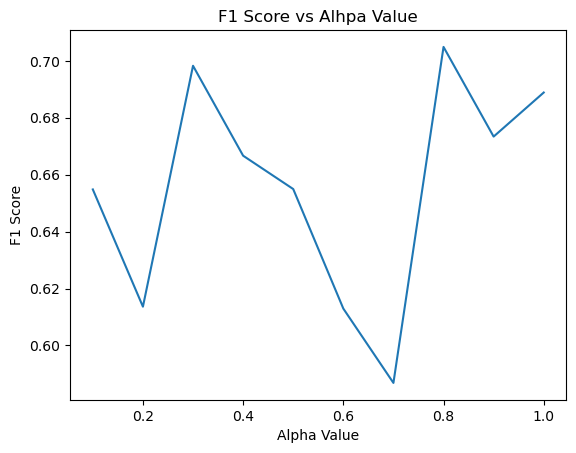

In [29]:
plt.plot(As,student_f1_results, label = "F1 Score")
plt.xlabel("Alpha Value")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Alhpa Value")
plt.show()

In [30]:
max_index = student_f1_results.index(max(student_f1_results))
Alpha_max = As[max_index]
print("Alpha Value with maximum F1 Score is: {}".format(Alpha_max))

Alpha Value with maximum F1 Score is: 0.8


## Train and Compare

In [40]:
#student model
student = student_model()

In [41]:
distiller = Distiller(student=student, teacher=teacher)
#From the previous fine tuning result, the alpha = 0.8 and T = 4
distiller.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_KD),
    metrics = [keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn = keras.losses.SparseCategoricalCrossentropy(),
    distillation_loss_fn = keras.losses.KLDivergence(),
    alpha = 0.8,
    temperature = 2
)
#Train student model with knpwledge distillation
reset_keras()
distiller.fit(train_images_normalized,train_labels_encoded,epochs =  FINE_TUNE_EPOCHS)


1925
Epoch 1/25
204/204 [==============================] - 19s 81ms/step - sparse_categorical_accuracy: 0.7136 - student_loss: 0.9047 - distillation_loss: 0.0275
Epoch 2/25
204/204 [==============================] - 16s 81ms/step - sparse_categorical_accuracy: 0.7533 - student_loss: 0.6719 - distillation_loss: 0.0228
Epoch 3/25
204/204 [==============================] - 16s 81ms/step - sparse_categorical_accuracy: 0.7746 - student_loss: 0.5817 - distillation_loss: 0.0206
Epoch 4/25
204/204 [==============================] - 16s 81ms/step - sparse_categorical_accuracy: 0.7911 - student_loss: 0.5233 - distillation_loss: 0.0190
Epoch 5/25
204/204 [==============================] - 16s 81ms/step - sparse_categorical_accuracy: 0.7933 - student_loss: 0.5156 - distillation_loss: 0.0186
Epoch 6/25
204/204 [==============================] - 16s 81ms/step - sparse_categorical_accuracy: 0.8081 - student_loss: 0.4537 - distillation_loss: 0.0168
Epoch 7/25
204/204 [==============================] -

In [42]:
reset_keras()
y_pred = student.predict(test_images_normalized)
y_pred = np.rint(y_pred)

800
31/31 [==============================] - 1s 23ms/step


In [43]:
result = np.argmax(y_pred,axis = 1)
f1_score_result = metrics.f1_score(test_labels_encoded, result)
print("Student Model with Knowledge Distillation f1 score: {}".format(f1_score_result))

Student Model with Knowledge Distillation f1 score: 0.6834437086092715


In [37]:
#Build Student from scratch
student_scratch = student_model()

student_scratch.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_SC),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
reset_keras()
student_scratch.fit(train_images_normalized, train_labels_encoded, epochs =  FINE_TUNE_EPOCHS)

1943
Epoch 1/25
204/204 [==============================] - 8s 30ms/step - loss: 0.9024 - sparse_categorical_accuracy: 0.7048
Epoch 2/25
204/204 [==============================] - 6s 30ms/step - loss: 0.6807 - sparse_categorical_accuracy: 0.7505
Epoch 3/25
204/204 [==============================] - 6s 30ms/step - loss: 0.6178 - sparse_categorical_accuracy: 0.7677
Epoch 4/25
204/204 [==============================] - 6s 30ms/step - loss: 0.5221 - sparse_categorical_accuracy: 0.7857
Epoch 5/25
204/204 [==============================] - 6s 30ms/step - loss: 0.5205 - sparse_categorical_accuracy: 0.7865
Epoch 6/25
204/204 [==============================] - 6s 30ms/step - loss: 0.4767 - sparse_categorical_accuracy: 0.8043
Epoch 7/25
204/204 [==============================] - 6s 30ms/step - loss: 0.4574 - sparse_categorical_accuracy: 0.8057
Epoch 8/25
204/204 [==============================] - 6s 30ms/step - loss: 0.5050 - sparse_categorical_accuracy: 0.8049
Epoch 9/25
204/204 [===============

In [38]:
#Pred on the test images
reset_keras()
y_pred = student_scratch.predict(test_images_normalized)
y_pred = np.rint(y_pred)

800
31/31 [==============================] - 1s 26ms/step


In [39]:
result = np.argmax(y_pred, axis = 1)
f1_score_result = metrics.f1_score(test_labels_encoded, result)
print("Student Model from Scratch F1 Score: {}".format(f1_score_result))

Student Model from Scratch F1 Score: 0.6598540145985401
